In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# 读取数据
df = pd.read_csv('../data/voucher_sample_20190122.csv')
# print(df.describe())
# print(df.head(10))
print(df.shape)

# 打印列头
print(df.columns)

(79386, 209)
Index(['promotion_id', 'asset_provider_voucher', 'asset_provider_promovoucher',
       'asset_provider_promonotice', 'asset_provider_promo',
       'asset_provider_outsalevoucher', 'asset_provider_other',
       'asset_type_secretvoucher', 'asset_type_exchangevoucher',
       'asset_type_nofundvoucher',
       ...
       'voucher_used_15d', 'voucher_good_15d', 'voucher_level_15d',
       'voucher_send_cnt_7d', 'voucher_use_cnt_7d', 'voucher_use_rate_7d',
       'voucher_used_7d', 'voucher_good_7d', 'voucher_level_7d', 'dt'],
      dtype='object', length=209)


In [4]:
# 不用的列
drop_columns = [
    'promotion_id',
    'show_monthday',
    'show_weekday',
    'dt'
]

# 标注列
label_columns = [
    'voucher_send_cnt_90d',
    'voucher_use_cnt_90d',
    'voucher_used_90d',
    'voucher_good_90d',
    'voucher_level_90d',
    'voucher_send_cnt_30d',
    'voucher_use_cnt_30d',
    'voucher_used_30d',
    'voucher_good_30d',
    'voucher_level_30d',
    'voucher_send_cnt_15d',
    'voucher_use_cnt_15d',
    'voucher_used_15d',
    'voucher_good_15d',
    'voucher_level_15d',
    'voucher_send_cnt_7d',
    'voucher_use_cnt_7d',
    'voucher_used_7d',
    'voucher_good_7d',
    'voucher_level_7d',
    'voucher_use_rate_90d',
    'voucher_use_rate_30d',
    'voucher_use_rate_15d',
    'voucher_use_rate_7d'
]

In [5]:
# 特征集合
x_data = df.drop(drop_columns, axis=1).drop(label_columns, axis=1)
print(x_data.shape)
# print(x_data.head())
x_data.head(5)

(79386, 181)


,asset_provider_voucher,asset_provider_promovoucher,asset_provider_promonotice,asset_provider_promo,asset_provider_outsalevoucher,asset_provider_other,asset_type_secretvoucher,asset_type_exchangevoucher,asset_type_nofundvoucher,asset_type_outsalevoucher,...,trade_amount_30d,trade_user_cnt_7d,trade_user_cnt_15d,trade_user_cnt_30d,trade_pct_7d,trade_pct_15d,trade_pct_30d,trade_pat_7d,trade_pat_15d,trade_pat_30d
0,0,0,0,1,0,0,0,0,0,0,...,82015456,316,672,1582,48527.784810,48768.811012,51842.892541,40783.989362,40610.459727,43509.525729
1,0,0,0,1,0,0,0,0,0,0,...,82015456,316,672,1582,48527.784810,48768.811012,51842.892541,40783.989362,40610.459727,43509.525729
2,0,0,0,1,0,0,0,0,0,0,...,42692858,155,298,671,59613.870968,71797.604027,63625.719821,50218.206522,62196.761628,53499.822055
3,0,1,0,0,0,0,0,1,0,0,...,82015456,316,672,1582,48527.784810,48768.811012,51842.892541,40783.989362,40610.459727,43509.525729
4,0,0,0,1,0,0,0,0,0,0,...,3324012,26,45,97,40886.076923,33175.666667,34268.164948,39371.777778,31763.936170,32588.352941


In [6]:
# 标注列
y_data = df['voucher_level_30d']
print(y_data.shape)
# print(y_data.head())
y_data.head()

(79386,)


0    0
1    0
2    0
3    0
4    0
Name: voucher_level_30d, dtype: int64

In [8]:
y_data.value_counts()

0    61774
1     8117
2     5712
3     1780
5     1070
4      818
6      115
Name: voucher_level_30d, dtype: int64

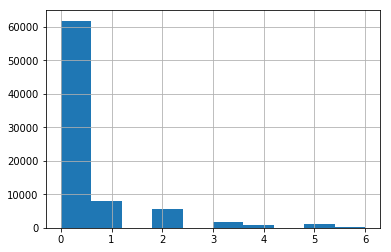

In [9]:
# 标注的分布
y_data.hist()

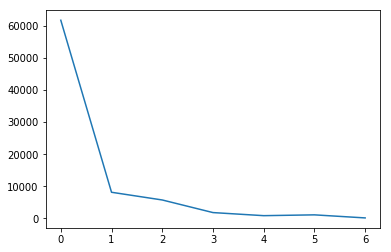

In [18]:
x_index = [0, 1, 2, 3, 4, 5, 6]
y_index = [61774, 8117, 5712, 1780, 818, 1070, 115]
plt.plot(x_index, y_index)

In [10]:
# 训练集测试集划分
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=0)
print(X_train.shape)
print(X_test.shape)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

(47631, 181)
(31755, 181)


In [19]:
# 算法参数
params = {
    'learning_rate': 0.1,   # 步长
    'n_estimators': 500,
    'max_depth': 5,         # 树的最大深度
    'objective': 'multi:softmax',
    'num_class': 7,
    'min_child_weight': 1,  # 决定最小叶子节点样本权重和，如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'gamma': 0,             # 指定了节点分裂所需的最小损失函数下降值。这个参数的值越大，算法越保守
    'subsample': 0.75,      # 每个决策树所用的子样本占总样本的比例（作用于样本）
    'colsample_bytree': 0.75,  # 建立树时对特征随机采样的比例（作用于特征）典型值：0.5-1
    'nthread': 8,
    'seed': 0,
    'silent': 1             # 输出运行信息
}

# 模型训练
num_round = 100
evallist = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_round, evallist)


[0]	train-merror:0.14816	test-merror:0.155409
[1]	train-merror:0.145535	test-merror:0.15374
[2]	train-merror:0.142134	test-merror:0.149236
[3]	train-merror:0.134786	test-merror:0.140797
[4]	train-merror:0.133925	test-merror:0.139065
[5]	train-merror:0.130482	test-merror:0.135664
[6]	train-merror:0.130083	test-merror:0.135412
[7]	train-merror:0.131112	test-merror:0.136294
[8]	train-merror:0.129558	test-merror:0.135506
[9]	train-merror:0.128782	test-merror:0.13475
[10]	train-merror:0.126892	test-merror:0.132452
[11]	train-merror:0.126745	test-merror:0.132546
[12]	train-merror:0.125423	test-merror:0.130436
[13]	train-merror:0.123911	test-merror:0.129177
[14]	train-merror:0.12284	test-merror:0.128263
[15]	train-merror:0.122588	test-merror:0.128389
[16]	train-merror:0.122882	test-merror:0.128956
[17]	train-merror:0.121706	test-merror:0.127854
[18]	train-merror:0.120489	test-merror:0.127161
[19]	train-merror:0.119271	test-merror:0.126185
[20]	train-merror:0.117906	test-merror:0.125114
[21]	t

In [20]:
# 预测分类
y_pred = model.predict(dtest)
print(y_pred.shape)
print(y_pred.dtype)
print(y_pred)
# print(y_test.shape)
# print(y_test.dtype)
# print(y_test.iloc[0])
# print(y_test.iloc[1])
# print(y_test)

(31755,)
float32
[1. 0. 0. ... 0. 0. 1.]


In [21]:
# 模型评估

# 错误率
# error_count = 0
# for i in range(len(y_pred)):
#     if y_pred[i] != y_test.iloc[i]:
#         print('y_pred[{index}]={y0}, y_test[{index}]={y1}'.format(index=i, y0=y_pred[i], y1=y_test.iloc[i]))
#         error_count += 1
        
# print(error_count)

error_count = sum( int(y_pred[i]) != y_test.iloc[i] for i in range(len(y_test)))
# print(error_count)

# 与模型预测的watchlist的test值相同
print('predicting, classification error = %f' % (error_count / float(len(y_test))))

# ACC
print ('ACC: %.4f' % metrics.accuracy_score(y_test, y_pred))

# 混淆矩阵
print(metrics.confusion_matrix(y_test, y_pred))

predicting, classification error = 0.095513
ACC: 0.9045
[[24393   336    59     2     0     0     0]
 [ 1016  1898   308     5     2     1     0]
 [  341   445  1424    54     6     5     0]
 [   31    32   185   398    24    11     0]
 [   13    10    27    27   200    42     0]
 [   10     9    10     1     8   373     2]
 [    1     1     1     0     0     8    36]]


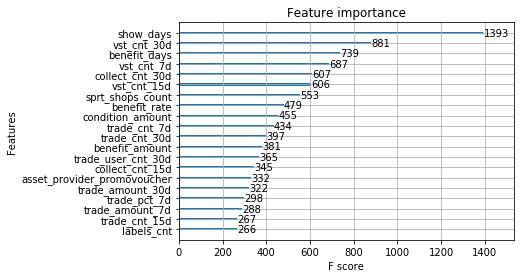

In [22]:
# 显示重要特征
plot_importance(model, max_num_features=20)
plt.show()